## Import Libraries

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

path = Path('/kaggle/input/5-flower-types-classification-dataset/flower_images')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
dataset = ImageFolder(path, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 4999
    Root location: /kaggle/input/5-flower-types-classification-dataset/flower_images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

## Split into Train and Validation Set

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Instantiate the model

In [7]:
import torchvision.models as models

model = models.resnet50(pretrained=True)

# Freeze the weights of the ResNet50 model
for param in model.parameters():
    param.requires_grad = False
    
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.0005, momentum=0.9)

## Train the model

In [9]:
num_epochs = 20

# Move the model to the GPU
model.to(device)

# Define dictionaries to store training and testing metrics
train_metrics = {'loss': [], 'accuracy': []}
test_metrics = {'loss': [], 'accuracy': []}

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Move input data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training metrics and store them in dictionary
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_metrics['loss'].append(epoch_loss)
    train_metrics['accuracy'].append(epoch_acc)
    print(f'Epoch {epoch + 1} training loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')

    # Evaluate the model on the test set and store metrics in dictionary
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    test_metrics['loss'].append(epoch_loss)
    test_metrics['accuracy'].append(epoch_acc)
    print(f'Test loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')

Epoch 1 training loss: 1.3375 accuracy: 0.5279
Test loss: 1.0237 accuracy: 0.7310
Epoch 2 training loss: 0.8469 accuracy: 0.8197
Test loss: 0.7577 accuracy: 0.8100
Epoch 3 training loss: 0.6675 accuracy: 0.8487
Test loss: 0.6452 accuracy: 0.8380
Epoch 4 training loss: 0.5826 accuracy: 0.8595
Test loss: 0.5831 accuracy: 0.8490
Epoch 5 training loss: 0.5334 accuracy: 0.8647
Test loss: 0.5462 accuracy: 0.8450
Epoch 6 training loss: 0.4956 accuracy: 0.8645
Test loss: 0.5184 accuracy: 0.8550
Epoch 7 training loss: 0.4673 accuracy: 0.8680
Test loss: 0.5055 accuracy: 0.8520
Epoch 8 training loss: 0.4478 accuracy: 0.8762
Test loss: 0.4820 accuracy: 0.8540
Epoch 9 training loss: 0.4316 accuracy: 0.8775
Test loss: 0.4650 accuracy: 0.8640
Epoch 10 training loss: 0.4179 accuracy: 0.8772
Test loss: 0.4499 accuracy: 0.8600
Epoch 11 training loss: 0.3952 accuracy: 0.8852
Test loss: 0.4456 accuracy: 0.8700
Epoch 12 training loss: 0.3920 accuracy: 0.8845
Test loss: 0.4389 accuracy: 0.8620
Epoch 13 trai

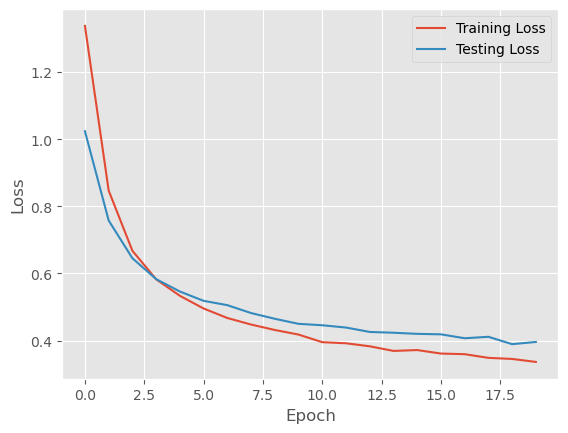

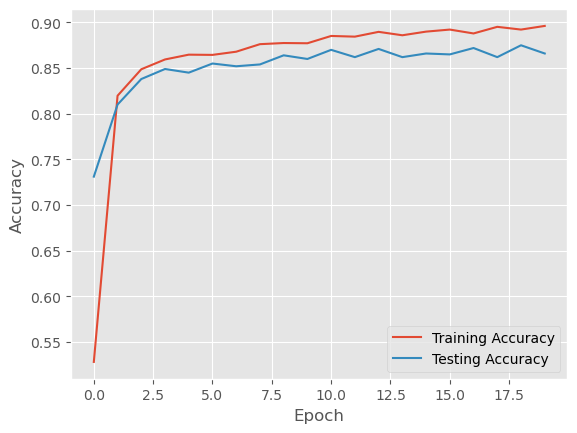

In [10]:
import matplotlib.pyplot as plt

# Plot training and testing loss
plt.plot(train_metrics['loss'], label='Training Loss')
plt.plot(test_metrics['loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.plot(train_metrics['accuracy'], label='Training Accuracy')
plt.plot(test_metrics['accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

If you like this notebook, don't forget to **upvote** this notebook!!!
Leave comments if you have any suggestions to improve it.